In [5]:
#1
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio

In [6]:
#2
DATASET_ROOT = r"C:\Users\Yasasi\SR-Test2\audio"

AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

In [7]:
#3
VALID_SPLIT = 0.1

SHUFFLE_SEED = 43

SAMPLING_RATE = 16000

SCALE = 0.5

BATCH_SIZE = 128

EPOCHS = 100

In [8]:
#4
# If folder audio, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder noise, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

#listdir() returns a list containing the names of the entries in the directory given by path.
for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is audio or noise, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples move it to the noise folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to audio folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

In [9]:
#5
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print("Found {} files belonging to {} directories".format(len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))))

Found 6 files belonging to 2 directories


In [10]:
#6
#Resample all noise samples to 16000 Hz
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(  #DECODE
        tf.io.read_file(path), desired_channels=1  #which reads wav file into tensor of type string
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


In [11]:
#https://www.tensorflow.org/guide/tensor
#Tensors are multi-dimensional arrays with a uniform type (called a dtype).

#Shape: The length (number of elements) of each of the axes of a tensor.
#Rank: Number of tensor axes. A scalar has rank 0, a vector has rank 1, a matrix is rank 2.
#Axis or Dimension: A particular dimension of a tensor.
#Size: The total number of items in the tensor, the product shape vector.

In [12]:
#7
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)  #get the slices of an array in the form of objects
    #MAP -applies a function on all the items of an iterator given as input.(can be a list,)
    #lambda function can take any number of arguments, but can only have one expression.
    audio_ds = path_ds.map(lambda x: path_to_audio(x))  
    label_ds = tf.data.Dataset.from_tensor_slices(labels)  
    #Dataset.zip transformation takes multiple datasets and iterates through them in parallel.
    return tf.data.Dataset.zip((audio_ds, label_ds))  


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path) #Reads the contents of file.
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE) #??
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        
        #The uniform distribution defines equal probability over a given range for a continuous distribution
        #Outputs random values from a uniform distribution.
        #dtype - The type of the output: int32
        #shape - A 1-D integer Tensor or Python array ??
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0) #Gather slices from params axis according to indices. 

        # Get the amplitude proportion between the audio and the noise
        #Computes tf.math.maximum of elements across dimensions of a tensor.
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        #Repeat elements of input. 
        #Returns a tensor with a length 1 axis inserted at index axis. #The new axis location matches Python (=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1) #Removes dimensions of size 1 from the shape of a tensor.  (axis=-1) ??
    #Fast Fourier transform.
    fft = tf.signal.fft(
        #Casts a tensor to a new type. tf.cast() for tensor type conversion
        #tf.zeros_like -Creates a tensor with all elements set to zero.
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1) #Returns a tensor with a length 1 axis inserted at index axis

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    #Computes the absolute value of a tensor.
    return tf.math.abs(fft[:, : (audio.shape[1]), :]) #get the shape of audio 


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,)) # replacement fields and placeholders defined {} 

audio_paths = []
labels = []
for label, name in enumerate(class_names): #iterable and returns it according to list
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav") #endswith() method returns True if the string ends with the specified value,else False.
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths) #unction returns the number of items in an object.

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
#RandomState exposes a number of methods for generating random numbers drawn from a variety of probability distributions.
rng = np.random.RandomState(SHUFFLE_SEED) 
rng.shuffle(audio_paths)  #Shuffle a list 
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples)) #training set 
train_audio_paths = audio_paths[:-num_val_samples] #??
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples)) #Validation set
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
# train_ds = train_ds.map(
#     lambda x, y: (add_noise(x, noises, scale=SCALE), y),
#     num_parallel_calls=tf.data.experimental.AUTOTUNE,
# )

# Transform audio wave to the frequency domain using `audio_to_fft`
# train_ds = train_ds.map(
#     lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
# )

 #prefetch -This allows later elements to be prepared while the current element is being processed
 #experimental -Public API for tf.experimental namespace.
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)#AUTOTUNE ??
train_ds = train_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))
print("--------")
print(train_ds)

# valid_ds = valid_ds.map(
#     lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
# )
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

Our class names: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela', 'yasasi']
Processing speaker Benjamin_Netanyau
Processing speaker Jens_Stoltenberg
Processing speaker Julia_Gillard
Processing speaker Magaret_Tarcher
Processing speaker Nelson_Mandela
Processing speaker yasasi
Found 7802 files belonging to 6 classes.
Using 7022 files for training.
Using 780 files for validation.
--------
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>


In [13]:
#1
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    #"same" results in padding with zeros evenly to the left/right or up/down of the 
    #input such that output has the same height/width dimension as the input. 
    #conv1D: (batch_size,W,channels) 
    s = keras.layers.Conv1D(filters, 1, padding="same")(x) #1D convolution layer #x ??
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)   #Applies an activation function to an output. ("relu".) 
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])           #Layer that adds a list of inputs.
    x = keras.layers.Activation(activation)(x)  
    # strides -pooling window moves for each pooling step.
    #pool_size -size of the max pooling window.
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x) #Max pooling operation for 1D temporal data.

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input") #Layer to be used as an entry point into a Network

    x = residual_block(inputs, 16, 2) #Residual Block from ResNet Architecture  #resblock(x, kernelsize, filters) 
    x = residual_block(x, 32, 2)  
    x = residual_block(x, 64, 3)  #64 3*3
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x) #Average pooling for temporal data.
    x = keras.layers.Flatten()(x)  #Flattens the input. Does not affect the batch size.(batch_size, 2,2),output(batch_size, 4)
    x = keras.layers.Dense(256, activation="relu")(x) #output = activation(dot(input, kernel) + bias)
    x = keras.layers.Dense(128, activation="relu")(x) #128 - (units) - dimensionality of the output space.

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)  #backward propagation

    return keras.models.Model(inputs=inputs, outputs=outputs)  #Resets the state of all the metrics in the model.


model = build_model((SAMPLING_RATE, 1), len(class_names))

model.summary() #get a summary of my network's structure 

# Compile the model using Adam's default learning rate
#The cache is cleared whenever Model.compile is called.
#Compile defines the loss function, the optimizer and the metrics
model.compile(     
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

#early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, 
#such as gradient descent
#Number of epochs with no improvement after which training will be stopped.

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#Callback to save the Keras model or model weights at some frequency.
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 16000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16000, 16)    64          input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 16)    0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16000, 16)    784         activation[0][0]                 
_______________________________________________________________________________________

In [14]:
#1
#measure of how well a machine learning model generalizes to similar data to that on which it was trained.
history = model.fit(  # train the model with model.fit()
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
55/55 [==============================] - 450s 8s/step - loss: 1.0739 - accuracy: 0.5221 - val_loss: 0.8194 - val_accuracy: 0.6090
Epoch 2/100
55/55 [==============================] - 396s 7s/step - loss: 0.5362 - accuracy: 0.7757 - val_loss: 0.4756 - val_accuracy: 0.8038
Epoch 3/100
55/55 [==============================] - 408s 7s/step - loss: 0.3789 - accuracy: 0.8453 - val_loss: 0.3595 - val_accuracy: 0.8359
Epoch 4/100
55/55 [==============================] - 421s 8s/step - loss: 0.3003 - accuracy: 0.8728 - val_loss: 0.3182 - val_accuracy: 0.8782
Epoch 5/100
55/55 [==============================] - 419s 8s/step - loss: 0.2928 - accuracy: 0.8817 - val_loss: 0.2924 - val_accuracy: 0.8795
Epoch 6/100
55/55 [==============================] - 454s 8s/step - loss: 0.2055 - accuracy: 0.9188 - val_loss: 0.3296 - val_accuracy: 0.8692
Epoch 7/100
55/55 [==============================] - 427s 8s/step - loss: 0.2140 - accuracy: 0.9120 - val_loss: 0.2524 - val_accuracy: 0.8974
Epoch 

In [15]:
#1
#Returns the loss value & metrics values for the model in test mode.
print(model.evaluate(valid_ds))

25/25 [==============================] - 11s 455ms/step - loss: 0.0642 - accuracy: 0.9718
[0.06419152766466141, 0.971794843673706]


In [16]:
print(valid_ds)

<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>


In [17]:
#1
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch( #Randomly shuffles the elements of this dataset.

    BATCH_SIZE
)

#MAP -applies a function on all the items of an iterator given as input.(can be a list,)
#lambda function can take any number of arguments, but can only have one expression.
test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):  #function returns elements from array along the mentioned axis and indices.
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(audios)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY) #returns an integer number selected element from the specified range
    #numpy() method is pretty much straightforward. It converts a tensor object into an numpy.ndarray object
    audios = audios.numpy()[rnd, :, :]  
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]  #function returns indices of the max element of the array in a particular axis.

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        # print(model.evaluate(test_ds)[1])
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index] and model.evaluate(test_ds)[1] > 0.90:
            # print(model.evaluate(test_ds)[1])
            print(y_pred[index])
            print("Welcome")
        else:
            print("Sorry")
        # print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: Julia_Gillard	Predicted: Julia_Gillard
7/7 [==============================] - 9s 1s/step - loss: 0.0725 - accuracy: 0.9718
2
Welcome
Speaker: yasasi	Predicted: yasasi
7/7 [==============================] - 9s 1s/step - loss: 0.0763 - accuracy: 0.9744
5
Welcome
Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
7/7 [==============================] - 9s 1s/step - loss: 0.0673 - accuracy: 0.9744
1
Welcome
Speaker: Magaret_Tarcher	Predicted: Benjamin_Netanyau
Sorry
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
7/7 [==============================] - 10s 1s/step - loss: 0.0852 - accuracy: 0.9705
0
Welcome
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
7/7 [==============================] - 10s 1s/step - loss: 0.0737 - accuracy: 0.9756
0
Welcome
Speaker: yasasi	Predicted: Jens_Stoltenberg
Sorry
Speaker: J

In [18]:
#1
model.save('sample.h5')  #ave a model's architecture, weights, and training configuration in a single file/folder

In [19]:
#1
model = tf.keras.models.load_model('sample.h5')  #Loads a model saved via model.save().
model.layers[0].input_shape  # access the layers of the model  #input_shape ??

[(None, 16000, 1)]

In [20]:
#1
test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

#MAP -applies a function on all the items of an iterator given as input.(can be a list,)
#lambda function can take any number of arguments, but can only have one expression.
test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(audios)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, 1)
     #numpy() method is pretty much straightforward. It converts a tensor object into an numpy.ndarray object
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd] #function returns indices of the max element of the array in a particular axis.

    for index in range(1):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        # print(model.evaluate(test_ds)[1])
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index] and model.evaluate(test_ds)[1] > 0.90:
            print(model.evaluate(test_ds)[1]) ##Returns the loss value & metrics values for the model in test mode.
            print("Welcome")
        else:
            print("Sorry")
        # print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
7/7 [==============================] - 9s 1s/step - loss: 0.0833 - accuracy: 0.2051
Sorry


In [21]:
#1
path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\20.wav"]
print(path)
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))

test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
	# Get the signal FFT
	y_pred = model.predict(audios)
	# Take random samples
	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)#Returns the loss value & metrics values for the model in test mode
			print(a[1])
			if class_names[y_pred[index]] == "avish":
				print(model.evaluate(test_ds)[1])
				# print(model.evaluate(valid_ds,verbose=0)[1])
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

['C:\\Users\\Yasasi\\SR-Test2\\audio\\audio\\yasasi\\20.wav']
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.string)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: 5	Predicted: 5
25/25 [==============================] - 11s 437ms/step - loss: 0.0708 - accuracy: 0.2090
0.20897436141967773
Sorry
yasasi


In [22]:
#1
path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\120.wav"]
print(path)
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))

test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
	# Get the signal FFT
	y_pred = model.predict(audios)
	# Take random samples
	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)#Returns the loss value & metrics values for the model in test mode
			print(a[1])
			if class_names[y_pred[index]] == "Magaret_Tarcher":
				print(model.evaluate(test_ds)[1])
				# print(model.evaluate(valid_ds,verbose=0)[1])
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

['C:\\Users\\Yasasi\\SR-Test2\\audio\\audio\\yasasi\\120.wav']
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.string)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: 5	Predicted: 5
25/25 [==============================] - 11s 440ms/step - loss: 0.0827 - accuracy: 0.2077
0.20769231021404266
Sorry
yasasi


In [23]:
#1
path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\30.wav"]
print(path)
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))

test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
	# Get the signal FFT
	y_pred = model.predict(audios)
	# Take random samples
	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)#Returns the loss value & metrics values for the model in test mode
			print(a[1])
			if class_names[y_pred[index]] == "Nelson_Mandela":
				print(model.evaluate(test_ds)[1])
				# print(model.evaluate(valid_ds,verbose=0)[1])
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

['C:\\Users\\Yasasi\\SR-Test2\\audio\\audio\\yasasi\\30.wav']
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.string)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: 5	Predicted: 5
25/25 [==============================] - 11s 441ms/step - loss: 0.0745 - accuracy: 0.2077
0.20769231021404266
Sorry
yasasi


In [24]:
#1
path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\10.wav"]
print(path)
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))

test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
	# Get the signal FFT
	y_pred = model.predict(audios)
	# Take random samples
	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)#Returns the loss value & metrics values for the model in test mode
			print(a[1])
			if class_names[y_pred[index]] == "Julia_Gillard":
				print(model.evaluate(test_ds)[1])
				# print(model.evaluate(valid_ds,verbose=0)[1])
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

['C:\\Users\\Yasasi\\SR-Test2\\audio\\audio\\yasasi\\10.wav']
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.string)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: 5	Predicted: 5
25/25 [==============================] - 11s 425ms/step - loss: 0.0716 - accuracy: 0.2038
0.20384615659713745
Sorry
yasasi


In [25]:
#1
path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\200.wav"]
print(path)
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))

test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
	# Get the signal FFT
	y_pred = model.predict(audios)
	# Take random samples
	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)#Returns the loss value & metrics values for the model in test mode
			print(a[1])
			if class_names[y_pred[index]] == "Jens_Stoltenberg":
				print(model.evaluate(test_ds)[1])
				# print(model.evaluate(valid_ds,verbose=0)[1])
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

['C:\\Users\\Yasasi\\SR-Test2\\audio\\audio\\yasasi\\200.wav']
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.string)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: 5	Predicted: 5
25/25 [==============================] - 11s 445ms/step - loss: 0.0713 - accuracy: 0.2064
0.2064102590084076
Sorry
yasasi


In [26]:
#1
path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\0.wav"]
print(path)
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))

test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):
	# Get the signal FFT
	y_pred = model.predict(audios)
	# Take random samples
	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)#Returns the loss value & metrics values for the model in test mode
			print(a[1])
			if class_names[y_pred[index]] == "Jens_Stoltenberg":
				print(model.evaluate(test_ds)[1])
				# print(model.evaluate(valid_ds,verbose=0)[1])
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

['C:\\Users\\Yasasi\\SR-Test2\\audio\\audio\\yasasi\\0.wav']
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.string)>
<MapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int32)>
Speaker: 5	Predicted: 5
25/25 [==============================] - 11s 434ms/step - loss: 0.0694 - accuracy: 0.2026
0.20256410539150238
Sorry
yasasi


In [27]:
#1
def paths_to_dataset(audio_paths):
	"""Constructs a dataset of audios and labels."""
	path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
	# audio_ds = path_ds.map(lambda x: path_to_audio(x))
	return tf.data.Dataset.zip((path_ds)) #Dataset.zip transformation takes multiple datasets and iterates through them in parallel.

def predict(path, labels):
	test = paths_and_labels_to_dataset(path, labels)


	test = test.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)
    #prefetch -This allows later elements to be prepared while the current element is being processed                            
	test = test.prefetch(tf.data.experimental.AUTOTUNE) 

#MAP -applies a function on all the items of an iterator given as input.(can be a list,)
#lambda function can take any number of arguments, but can only have one expression.
	test = test.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

	for audios, labels in test.take(1):
		# Get the signal FFT
		ffts = audio_to_fft(audios)
		# Predict
		y_pred = model.predict(ffts)
		# Take random samples
		rnd = np.random.randint(0, 1, 1)
		audios = audios.numpy()[rnd, :]
		labels = labels.numpy()[rnd]
		y_pred = np.argmax(y_pred, axis=-1)[rnd]

		for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			if class_names[y_pred[index]] == "Jens_Stoltenberg":
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

# predict("content/1000.wav")

path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\10.wav"]
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))


predict(path, labels)
# except:
#     print("Error! Check if the file correctly passed or not!")

Speaker: 4	Predicted: 4
Sorry
Nelson_Mandela


In [28]:
#1
def paths_to_dataset(audio_paths):
	"""Constructs a dataset of audios and labels."""
	path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
	# audio_ds = path_ds.map(lambda x: path_to_audio(x))
	return tf.data.Dataset.zip((path_ds)) #Dataset.zip transformation takes multiple datasets and iterates through them in parallel.

def predict(path, labels):
	test = paths_and_labels_to_dataset(path, labels)


	test = test.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)
    #prefetch -This allows later elements to be prepared while the current element is being processed                            
	test = test.prefetch(tf.data.experimental.AUTOTUNE) 

#MAP -applies a function on all the items of an iterator given as input.(can be a list,)
#lambda function can take any number of arguments, but can only have one expression.
	test = test.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

	for audios, labels in test.take(1):
		# Get the signal FFT
		ffts = audio_to_fft(audios)
		# Predict
		y_pred = model.predict(ffts)
		# Take random samples
		rnd = np.random.randint(0, 1, 1)
		audios = audios.numpy()[rnd, :]
		labels = labels.numpy()[rnd]
		y_pred = np.argmax(y_pred, axis=-1)[rnd]

		for index in range(1):
			# For every sample, print the true and predicted label
			# as well as run the voice with the noise
			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			if class_names[y_pred[index]] == "Julia_Gillard":
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])
			# display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

# predict("content/1000.wav")

path = [r"C:\Users\Yasasi\SR-Test2\audio\audio\yasasi\20.wav"]
labels = ["unknown"]

# path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
# audio_ds = path_ds.map(lambda x: path_to_audio(x))
# label_ds = tf.data.Dataset.from_tensor_slices(labels)
# return tf.data.Dataset.zip((audio_ds, label_ds))


predict(path, labels)
# except:
#     print("Error! Check if the file correctly passed or not!")

Speaker: 4	Predicted: 4
Sorry
Nelson_Mandela


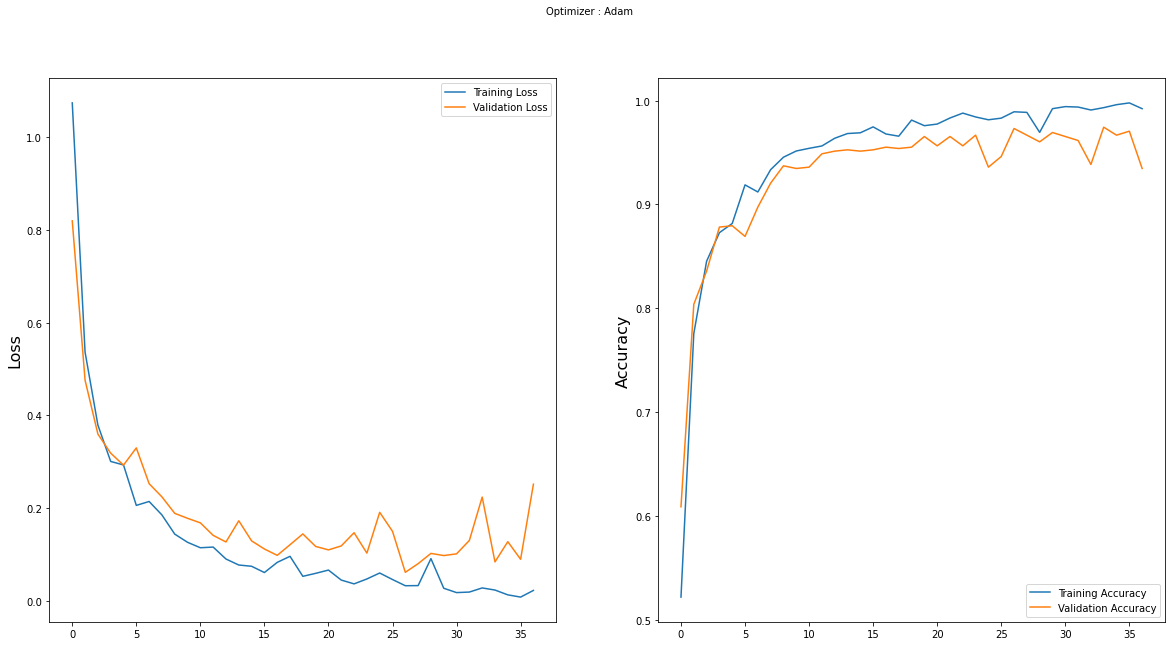

In [29]:
#1
import matplotlib.pyplot as plt

# plot the evolution of Loss and Acuracy on the train and validation sets
# Create a figure of size 20x10 inches
plt.figure(figsize=(20,10))
# Create a new subplot from a grid of 1x2x1
plt.subplot(1, 2, 1)
#Add a centered suptitle to the figure.
plt.suptitle('Optimizer : Adam', fontsize=10)
#y lable
plt.ylabel('Loss', fontsize=16)
# summarize history for loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#location of the legend.
plt.legend(loc='upper right')
# Create a new subplot from a grid of 1x2x1
plt.subplot(1, 2, 2)
#ylable
plt.ylabel('Accuracy', fontsize=16)
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [30]:
predicted_target_all=[]
actual_target_all=[]
for val_ds in valid_ds:
    
    test_data=val_ds[0]
    test_target=val_ds[1]
    predicted_target=model.predict(test_data)
    predicted_target_all.append(np.argmax(predicted_target,axis=1).flatten())
    actual_target_all.append(np.array(test_target).flatten())
predicted_target_all=np.concatenate(predicted_target_all,axis=0)
actual_target_all=np.concatenate(actual_target_all,axis=0)

In [31]:
predicted_target_all.shape

(780,)

In [32]:
actual_target_all.shape

(780,)

In [33]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

matrix=confusion_matrix(actual_target_all,predicted_target_all)
print(matrix)

[[149   5   0   0   0   0]
 [  6 134   0   0   0   0]
 [  1   2 149   0   0   0]
 [  7   1   0 139   0   0]
 [  0   0   1   0 144   0]
 [  0   0   0   0   0  42]]


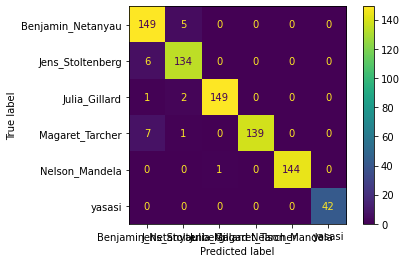

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela', 'yasasi'])

disp.plot()


In [51]:
 plt.savefig('confusion_matrix.png')
    

<Figure size 432x288 with 0 Axes>

In [52]:
from sklearn.metrics import classification_report

print(classification_report(actual_target_all,predicted_target_all,target_names=['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela', 'yasasi']))


                   precision    recall  f1-score   support

Benjamin_Netanyau       0.91      0.97      0.94       154
 Jens_Stoltenberg       0.94      0.96      0.95       140
    Julia_Gillard       0.99      0.98      0.99       152
  Magaret_Tarcher       1.00      0.95      0.97       147
   Nelson_Mandela       1.00      0.99      1.00       145
           yasasi       1.00      1.00      1.00        42

         accuracy                           0.97       780
        macro avg       0.98      0.97      0.97       780
     weighted avg       0.97      0.97      0.97       780

